In [1]:
from fastai import *
from fastai.vision import *
from tqdm import tqdm_notebook as tqdm
import os
import cv2

import random
import numpy as np
import keras
from random import shuffle
from keras.utils import np_utils
from shutil import unpack_archive
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf

%reload_ext autoreload
%autoreload 2
%matplotlib inline


Using TensorFlow backend.


In [2]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-cp36-none-any.whl size=25851 sha256=be1f3ca0152b0d84a61f718cfc22ce7a7f47a3aa15f2bc1f1f63dc8416aef1ea
  Stored in directory: /root/.cache/pip/wheels/16/84/1f/bf88641293cda2c8be81a5c4b8ca973dd9125a6dc3767417fd
Successfully built imutils


# TẬP DỮ LIỆU  

In [3]:
data = (ImageList.from_folder("/kaggle/input/naruto-hand-sign-dataset/Pure Naruto Hand Sign Data/")\
        .split_by_rand_pct()          
        .label_from_folder()
        .add_test_folder() 
        .transform(get_transforms(),size=224)
        .databunch()
        .normalize(imagenet_stats))
data 

ImageDataBunch;

Train: LabelList (1796 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dragon,dragon,dragon,dragon,dragon
Path: /kaggle/input/naruto-hand-sign-dataset/Pure Naruto Hand Sign Data;

Valid: LabelList (449 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
ox,snake,rat,rat,monkey
Path: /kaggle/input/naruto-hand-sign-dataset/Pure Naruto Hand Sign Data;

Test: LabelList (86 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /kaggle/input/naruto-hand-sign-dataset/Pure Naruto Hand Sign Data

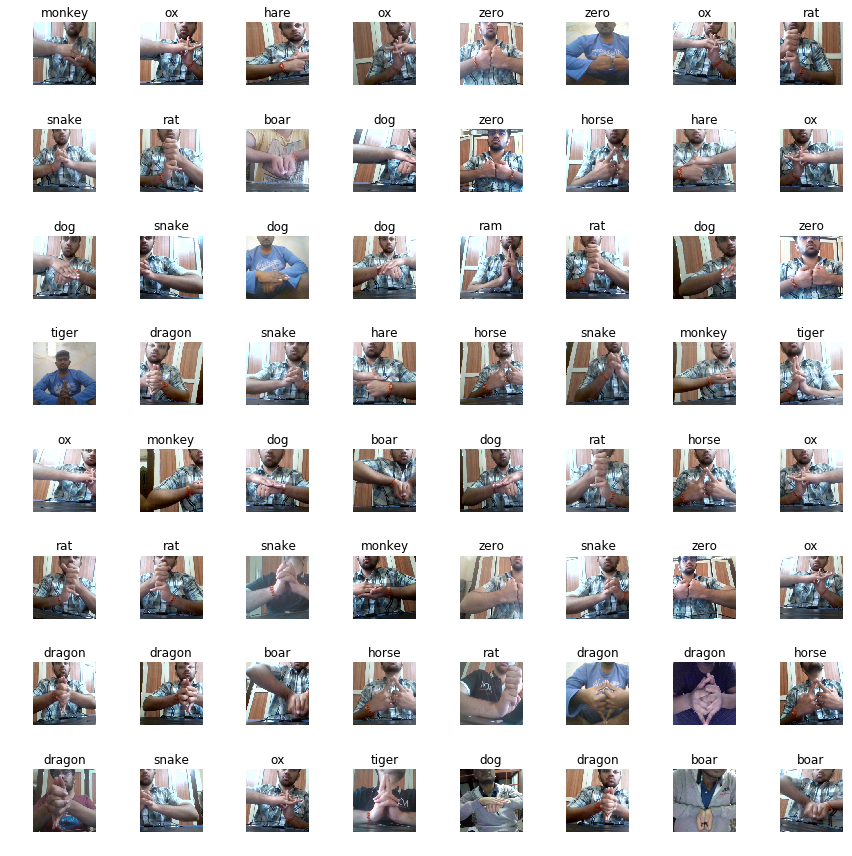

In [4]:
data.show_batch(rows=20, figsize=(12,12))

In [5]:
from fastai.metrics import error_rate 

learn = cnn_learner(data, models.vgg16_bn , metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [6]:
learn.model_dir="/kaggle/working/models"

# WARM UP

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


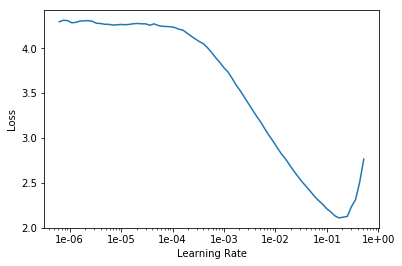

In [7]:
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(4,1e-02)
learn.model_dir="/kaggle/working/models"
learn.save('Hand-Sign-detection-stage-1')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.314458,0.307534,0.915367,0.084633,01:46
1,0.652964,0.167024,0.953229,0.046771,01:44
2,0.370930,0.053508,0.988864,0.011136,01:45
3,0.225339,0.045696,0.991091,0.008909,01:43


[0.04569578, tensor(0.9911), tensor(0.0089)]


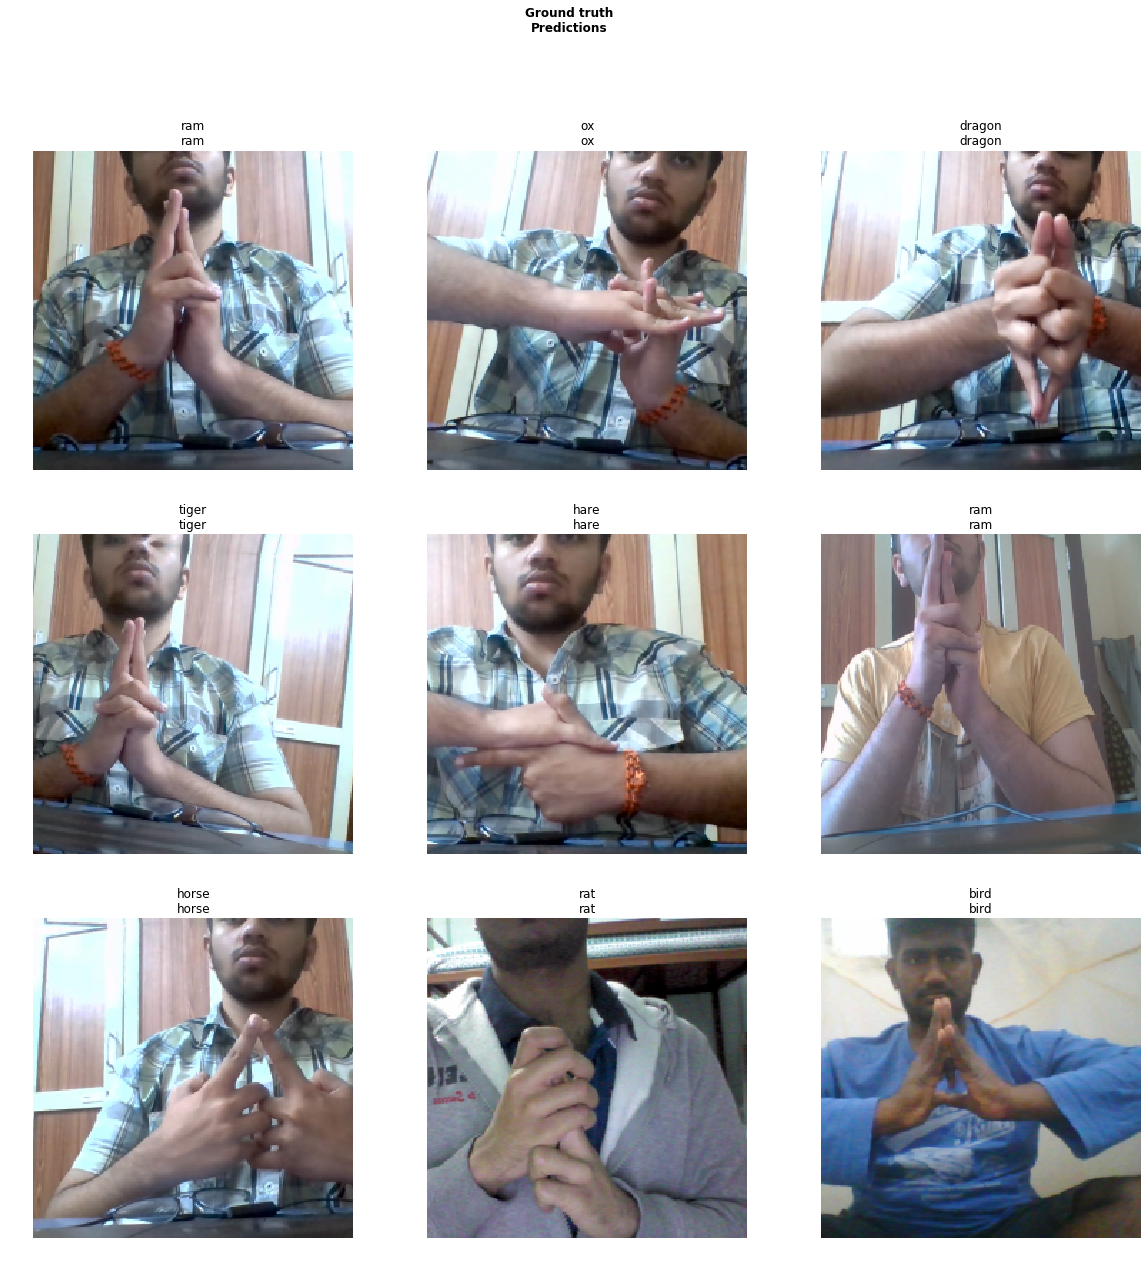

In [9]:
learn.validate()
print(learn.validate())
learn.show_results(ds_type=DatasetType.Train, rows=3, figsize=(20,20))

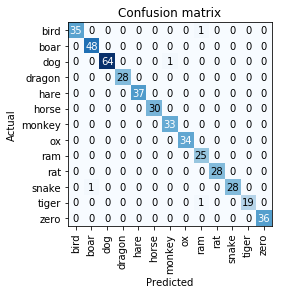

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

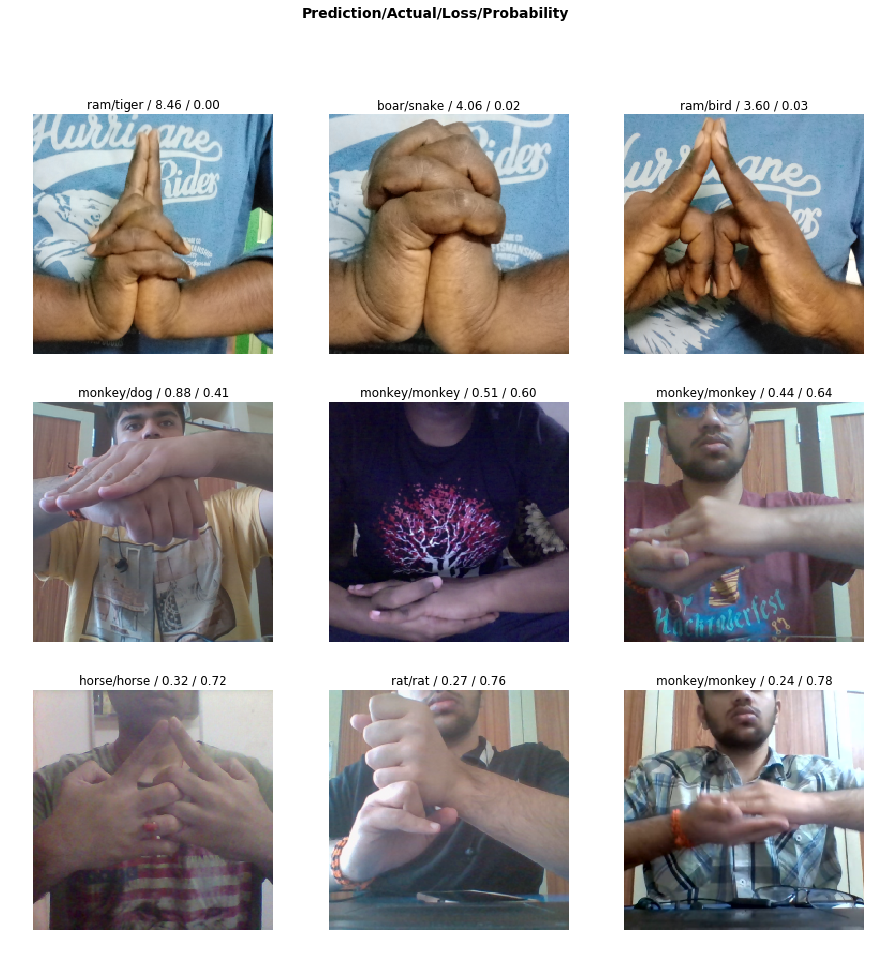

In [11]:
interp.plot_top_losses(9, figsize=(15,15))

# FINE TUNNING

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


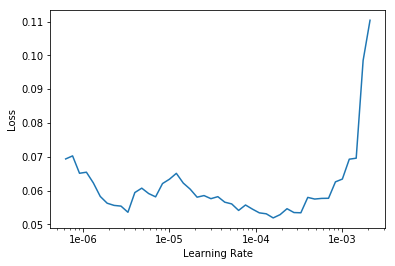

In [12]:
learn.unfreeze() 
learn.lr_find()
learn.recorder.plot()

In [14]:
#learn.fit_one_cycle(8, max_lr=slice(1e-06, 1e-05))
learn.fit_one_cycle(8,  max_lr=slice(1e-05, 1e-04))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.068254,0.042557,0.991091,0.008909,01:47
1,0.050798,0.043649,0.991091,0.008909,01:47
2,0.043218,0.036310,0.991091,0.008909,01:49
3,0.037189,0.031658,0.993318,0.006682,02:01
4,0.029112,0.037117,0.991091,0.008909,02:04
5,0.025277,0.034890,0.991091,0.008909,02:04
6,0.021953,0.035521,0.991091,0.008909,02:05
7,0.021143,0.033410,0.991091,0.008909,02:06


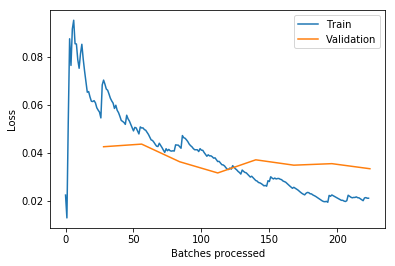

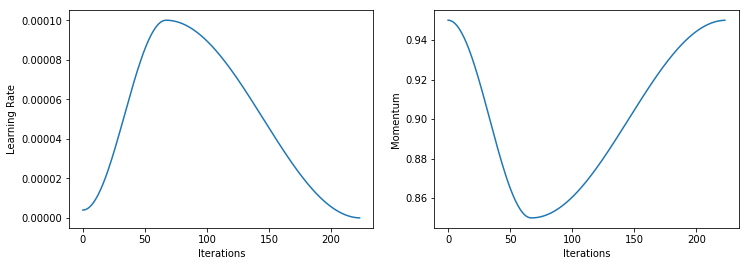

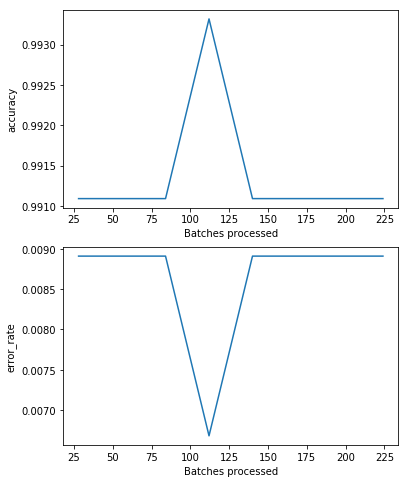

In [15]:
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

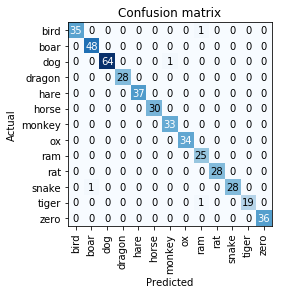

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [22]:
learn.save('Hand-Sign-detection-stage-2')

# KIỂM TRA MÔ HÌNH TRÊN TẬP KIỂM ĐỊNH

In [17]:
y_preds= learn.get_preds(DatasetType.Valid)
y_preds


[tensor([[9.3322e-12, 1.3463e-14, 2.1832e-12,  ..., 5.0050e-13, 4.4702e-13,
          1.9183e-14],
         [9.9696e-07, 1.3992e-07, 1.6862e-06,  ..., 9.9965e-01, 1.2280e-06,
          8.3279e-06],
         [8.7157e-10, 2.2269e-10, 2.2031e-10,  ..., 2.9126e-07, 2.0089e-09,
          4.4288e-11],
         ...,
         [3.4036e-10, 3.3701e-08, 9.9999e-01,  ..., 1.5503e-09, 2.2432e-11,
          7.1958e-09],
         [1.0000e+00, 3.3313e-09, 4.7366e-13,  ..., 2.6391e-10, 2.4038e-07,
          1.4885e-10],
         [6.0341e-09, 1.8038e-09, 4.5732e-13,  ..., 7.6227e-09, 1.0000e+00,
          7.6042e-10]]),
 tensor([ 7, 10,  9,  9,  6,  6,  9,  7,  2,  7,  0, 10,  1,  1,  0,  1,  1, 12,
          4,  0,  1,  8,  2, 10, 12,  2,  2,  0,  1,  5,  9,  9,  6,  9,  2, 11,
          2,  4,  1,  0,  8,  2,  6,  8,  6,  7,  4, 10,  8,  6,  4,  1,  5,  3,
          1,  1,  4,  3, 12, 12,  9, 12,  2,  4,  7,  2,  2,  9,  4,  4,  4,  3,
          8,  5,  2, 12,  2,  9,  3, 10,  2,  6,  1,  4,  3,  7,  

Kiểm tra bằng một ảnh tự chụp

In [18]:
arr = cv2.imread("../input/image-test/Dragon.jpg")
img = pil2tensor(arr,dtype= np.float32)
pred= learn.predict(Image(img))
pred

(Category dragon,
 tensor(3),
 tensor([0.0000e+00, 5.8009e-26, 3.7059e-14, 1.0000e+00, 0.0000e+00, 5.8304e-40,
         1.0003e-34, 1.5774e-31, 2.8500e-19, 2.0527e-30, 0.0000e+00, 0.0000e+00,
         2.7432e-09]))

In [19]:
data_test = (ImageList.from_folder("../input/naruto-hand-sign-dataset/Pure Naruto Hand Sign Data/test")\
        .split_by_rand_pct()          
        .label_from_folder()
        .add_test_folder() 
        .transform(get_transforms(),size=224)
        .databunch()
        .normalize(imagenet_stats))
data_test

ImageDataBunch;

Train: LabelList (69 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
dragon,dragon,dragon,dragon,dragon
Path: ../input/naruto-hand-sign-dataset/Pure Naruto Hand Sign Data/test;

Valid: LabelList (17 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
tiger,zero,tiger,ox,monkey
Path: ../input/naruto-hand-sign-dataset/Pure Naruto Hand Sign Data/test;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: ../input/naruto-hand-sign-dataset/Pure Naruto Hand Sign Data/test

In [20]:
def evaluate_model(interp, data_test):
    ok_pred = 0
    
    for idx, raw_p in enumerate(interp.preds):
        pred = np.argmax(raw_p)
        if pred == interp.y_true[idx]:
            ok_pred += 1
    
    print("True predicted cases: ", ok_pred)
    print("Total cases: ", len(interp.y_true))
    acc = ok_pred / len(interp.y_true)
    print(f'Overall accuracy of the model: {acc*100}%')

In [21]:
evaluate_model(interp, data_test)

True predicted cases:  445
Total cases:  449
Overall accuracy of the model: 99.10913140311804%


# KIỂM TRA MÔ HÌNH TRÊN TẬP KIỂM TRA

In [23]:
preds, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
labels  = torch.argmax(preds, dim=1)
test_predictions_direct = [data.classes[int(x)] for x in labels]
test_predictions_direct

['dragon',
 'dragon',
 'dragon',
 'dragon',
 'dragon',
 'dragon',
 'dragon',
 'dragon',
 'dragon',
 'dragon',
 'ram',
 'ram',
 'ram',
 'ram',
 'ram',
 'bird',
 'bird',
 'bird',
 'bird',
 'monkey',
 'monkey',
 'monkey',
 'monkey',
 'monkey',
 'horse',
 'horse',
 'horse',
 'horse',
 'horse',
 'snake',
 'snake',
 'snake',
 'snake',
 'snake',
 'rat',
 'rat',
 'rat',
 'rat',
 'rat',
 'tiger',
 'tiger',
 'tiger',
 'tiger',
 'tiger',
 'ox',
 'ox',
 'ox',
 'ox',
 'ox',
 'ox',
 'ox',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'boar',
 'boar',
 'boar',
 'boar',
 'boar',
 'boar',
 'boar',
 'boar',
 'boar',
 'boar',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'hare',
 'dog',
 'dog',
 'monkey',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog',
 'dog']